In [1]:
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import requests
import bs4

pd.options.display.float_format = '{:,.3f}'.format

<br> 오늘이 2022년 4월 1일라고 가정하고 어떤 종목들이 추천되는 지 보겠습니다. 먼저 오늘 기준으로 100 일전 날짜를 timedelta 를 이용해 찾습니다. 

In [20]:
import datetime
today_dt = '2022-04-01'
today = datetime.datetime.strptime(today_dt, '%Y-%m-%d')
start_dt = today - datetime.timedelta(days=100) # 100 일전 데이터 부터 시작 - 피쳐 엔지니어링은 최소 60 개의 일봉이 필요함
print(start_dt, today_dt)

2021-12-22 00:00:00 2022-04-01


<br> 위 코드에서 찾은 시작일부터 오늘까지 종목별로 100개의 일봉을 가져와서 데이터셋을 구성합니다.

In [21]:
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

price_data = pd.DataFrame()

for code, name in zip(kosdaq_list['code'], kosdaq_list['name']):  # 코스닥 모든 종목에서 대하여 반복
    daily_price = fdr.DataReader(code,  start = start_dt, end = today_dt) # 종목, 일봉, 데이터 갯수
    daily_price['code'] = code
    daily_price['name'] = name
    price_data = pd.concat([price_data, daily_price], axis=0)   

price_data.index.name = 'date'
price_data.columns= price_data.columns.str.lower() # 컬럼 이름 소문자로 변경

<br> 주가지수 데이터를 가져오고, 일봉데이터에 추가합니다.

In [22]:
kosdaq_index = fdr.DataReader('KQ11', start = start_dt, end = today_dt) # 데이터 호출
kosdaq_index.columns = ['close','open','high','low','volume','change'] # 컬럼명 변경
kosdaq_index.index.name='date' # 인덱스 이름 생성
kosdaq_index.sort_index(inplace=True) # 인덱스(날짜) 로 정렬 
kosdaq_index['kosdaq_return'] = kosdaq_index['close']/kosdaq_index['close'].shift(1) # 수익율 : 전 날 종가대비 당일 종가

merged = price_data.merge(kosdaq_index['kosdaq_return'], left_index=True, right_index=True, how='left')

<br> 주가 지수 수익률과 종목별 수익율을 비교한 결과를 win_market 이라는 변수에 담습니다. 

In [23]:
return_all = pd.DataFrame()

for code in kosdaq_list['code']:  
    
    stock_return = merged[merged['code']==code].sort_index()
    stock_return['return'] = stock_return['close']/stock_return['close'].shift(1) # 종목별 전일 종가 대비 당일 종가 수익율
    c1 = (stock_return['kosdaq_return'] < 1) # 수익율 1 보다 작음. 당일 종가가 전일 종가보다 낮음 (코스닥 지표)
    c2 = (stock_return['return'] > 1) # 수익율 1 보다 큼. 당일 종가가 전일 종가보다 큼 (개별 종목)
    stock_return['win_market'] = np.where((c1&c2), 1, 0) # C1 과 C2 조건을 동시에 만족하면 1, 아니면 0
    return_all = pd.concat([return_all, stock_return], axis=0) 
    
return_all.dropna(inplace=True)    

In [24]:
return_all.head()

,open,high,low,close,volume,change,code,name,kosdaq_return,return,win_market
date,,,,,,,,,,,
2021-12-23,3195,3260,3195,3220,104180,-0.002,060310,3S,1.003,0.998,0
2021-12-24,3230,3355,3220,3290,238933,0.022,060310,3S,1.004,1.022,0
2021-12-27,3290,3380,3275,3305,130826,0.005,060310,3S,1.004,1.005,0
2021-12-28,3355,3355,3180,3190,267316,-0.035,060310,3S,1.016,0.965,0
2021-12-29,3200,3350,3200,3330,115094,0.044,060310,3S,1.001,1.044,0


<br>  모델에 입력할 변수를 생성합니다.

In [25]:
model_inputs = pd.DataFrame()

for code, name, sector in zip(kosdaq_list['code'], kosdaq_list['name'], kosdaq_list['sector']):

    data = return_all[return_all['code']==code].sort_index().copy()    
    
    # 가격변동성이 크고, 거래량이 몰린 종목이 주가가 상승한다
    data['price_mean'] = data['close'].rolling(20).mean()
    data['price_std'] = data['close'].rolling(20).std(ddof=0)
    data['price_z'] = (data['close'] - data['price_mean'])/data['price_std']    
    data['volume_mean'] = data['volume'].rolling(20).mean()
    data['volume_std'] = data['volume'].rolling(20).std(ddof=0)
    data['volume_z'] = (data['volume'] - data['volume_mean'])/data['volume_std']
    
    # 위꼬리가 긴 양봉이 자주발생한다.
    data['positive_candle'] = (data['close'] > data['open']).astype(int) # 양봉
    data['high/close'] = (data['positive_candle']==1)*(data['high']/data['close'] > 1.1).astype(int) # 양봉이면서 고가가 종가보다 높게 위치
    data['num_high/close'] =  data['high/close'].rolling(20).sum()
    data['long_candle'] = (data['positive_candle']==1)*(data['high']==data['close'])*\
    (data['low']==data['open'])*(data['close']/data['open'] > 1.2).astype(int) # 장대 양봉을 데이터로 표현
    data['num_long'] =  data['long_candle'].rolling(60).sum() # 지난 20 일 동안 장대양봉의 갯 수
    
    
     # 거래량이 종좀 터지며 매집의 흔적을 보인다   
    data['volume_mean'] = data['volume'].rolling(60).mean()
    data['volume_std'] = data['volume'].rolling(60).std()
    data['volume_z'] = (data['volume'] - data['volume_mean'])/data['volume_std'] # 거래량은 종목과 주가에 따라 다르기 떄문에 표준화한 값이 필요함
    data['z>1.96'] = (data['close'] > data['open'])*(data['volume_z'] > 1.65).astype(int) # 양봉이면서 거래량이 90%신뢰구간을 벗어난 날
    data['num_z>1.96'] =  data['z>1.96'].rolling(60).sum()  # 양봉이면서 거래량이 90% 신뢰구간을 벗어난 날을 카운트
    
    # 주가지수보다 더 좋은 수익율을 보여준다
    data['num_win_market'] = data['win_market'].rolling(60).sum() # 주가지수 수익율이 1 보다 작을 때, 종목 수익율이 1 보다 큰 날 수
    data['pct_win_market'] = (data['return']/data['kosdaq_return']).rolling(60).mean() # 주가지수 수익율 대비 종목 수익율
    
    
    # 동종업체 수익률보다 더 좋은 수익율을 보여준다.           
    data['return_mean'] = data['return'].rolling(60).mean() # 종목별 최근 60 일 수익율의 평균
    data['sector'] = sector    
    data['name'] = name
     
    data = data[(data['price_std']!=0) & (data['volume_std']!=0)]    

    model_inputs = pd.concat([data, model_inputs], axis=0)

model_inputs['sector_return'] = model_inputs.groupby(['sector', model_inputs.index])['return'].transform(lambda x: x.mean()) # 섹터의 평균 수익율 계산
model_inputs['return over sector'] = (model_inputs['return']/model_inputs['sector_return']) # 섹터 평균 수익률 대비 종목 수익률 계산
model_inputs.dropna(inplace=True) # Missing 값 있는 행 모두 제거
model_inputs.to_pickle('model_inputs.pkl')

<br> 모델에 입력할 변수를 생성하고 X 에 담습니다.

In [26]:
# 최종 피처만으로 구성
model_inputs = pd.read_pickle('model_inputs.pkl')
feature_list = ['price_z','volume_z','num_high/close','num_win_market','pct_win_market','return over sector']

X = model_inputs.loc[today_dt][['code','name','return'] + feature_list].set_index('code') # 오늘 날짜 2022년 4월 1일 데이터만
X.head()

,name,return,price_z,volume_z,num_high/close,num_win_market,pct_win_market,return over sector
code,,,,,,,,
238490,힘스,0.997,-1.290,-0.519,0.000,6.000,1.000,1.002
037440,희림,0.981,0.144,-0.839,0.000,12.000,1.009,0.970
189980,흥국에프엔비,1.004,0.304,-0.555,0.000,14.000,1.002,1.000
010240,흥국,0.996,0.962,0.693,0.000,8.000,1.000,1.001
024060,흥구석유,1.011,-0.838,-0.590,0.000,15.000,1.006,1.012


<br> 저장한 GAM 모델을 불러 읽고, 입력변수를 넣어 예측값을 생성합니다. 입력변수의 순서는 모델에 사용한 입력변수와 동일해야 합니다.

In [27]:
import pickle
with open("gam.pkl", "rb") as file:
    gam = pickle.load(file)     
    
yhat = gam.predict_proba(X[feature_list])
X['yhat'] = yhat
X.head()

,name,return,price_z,volume_z,num_high/close,num_win_market,pct_win_market,return over sector,yhat
code,,,,,,,,,
238490,힘스,0.997,-1.290,-0.519,0.000,6.000,1.000,1.002,0.222
037440,희림,0.981,0.144,-0.839,0.000,12.000,1.009,0.970,0.298
189980,흥국에프엔비,1.004,0.304,-0.555,0.000,14.000,1.002,1.000,0.185
010240,흥국,0.996,0.962,0.693,0.000,8.000,1.000,1.001,0.229
024060,흥구석유,1.011,-0.838,-0.590,0.000,15.000,1.006,1.012,0.266


<br> 어떤 종목이 높은 종목을 받았는지 궁금합니다. 점수로 내림차순 정렬한 후 종목을 확인해 봅니다. 우리는 4월 1일 이후에 주가 흐름을 알고 있습니다. 4월 2일이후 데이터를 추가하여 모델이 유의미한지 점검해 보겠습니다.

In [28]:
X.sort_values(by='yhat', ascending=False)

,name,return,price_z,volume_z,num_high/close,num_win_market,pct_win_market,return over sector,yhat
code,,,,,,,,,
056090,에디슨INNO,1.080,-1.621,1.764,3.000,16.000,1.026,1.064,0.805
069920,아이에스이커머스,1.300,2.396,3.518,2.000,15.000,1.019,1.224,0.680
185490,아이진,0.908,-2.249,2.227,0.000,6.000,0.992,0.920,0.567
145020,휴젤,0.868,-3.379,7.109,0.000,6.000,0.998,0.868,0.553
053260,금강철강,1.027,1.392,3.239,4.000,9.000,1.010,1.033,0.526
...,...,...,...,...,...,...,...,...,...
321550,티움바이오,1.018,1.459,-0.802,0.000,8.000,1.000,1.031,0.145
123570,이엠넷,1.000,1.586,-1.150,0.000,8.000,1.001,1.010,0.143
051380,피씨디렉트,1.017,1.980,-0.613,0.000,11.000,1.000,1.019,0.142


In [37]:
outcome_data = pd.DataFrame()

today_dt = '2022-04-01'
end_dt = '2022-04-08'

for code in list(X.index):  # 스코어가 생성된 모든 종목에서 대하여 반복
    daily_price = fdr.DataReader(code,  start = today_dt, end = end_dt) # 종목, 일봉, 데이터 갯수
    daily_price['code'] = code
    outcome_data = pd.concat([outcome_data, daily_price], axis=0)      

In [57]:
outcome_data['close_r1'] = outcome_data['Close'].shift(-1)/outcome_data['Close']   # 4월 1일 종가 매수한 후 4월 4일 수익율
outcome_data['close_r2'] = outcome_data['Close'].shift(-2)/outcome_data['Close']   # 4월 1일 종가 매수한 후 4월 5일 수익율
outcome_data['close_r3'] = outcome_data['Close'].shift(-3)/outcome_data['Close']   # 4월 1일 종가 매수한 후 4월 6일 수익율
outcome_data['close_r4'] = outcome_data['Close'].shift(-4)/outcome_data['Close']   # 4월 1일 종가 매수한 후 4월 7일 수익율
outcome_data['close_r5'] = outcome_data['Close'].shift(-5)/outcome_data['Close']   # 4월 1일 종가 매수한 후 4월 8일 수익율

outcome_data['max_close'] = outcome_data[['close_r1','close_r2','close_r3','close_r4','close_r5']].max(axis=1)
outcome_data['min_close'] = outcome_data[['close_r1','close_r2','close_r3','close_r4','close_r5']].min(axis=1)

outcome_data['target'] = np.where(outcome_data['max_close']>=1.05, 1, 0)

<br> 스코어 파일에 결과 데이터를 병합합니다. 두 데이터셋의 인덱스는 종목이어야 병합이 가능합니다. 최고 종가 수익율 평균과 5% 익절할 확률의 평균을 스코어 구간별로 그래프를 그려봅니다. 스코어가 높은 구간에서 5% 이상 익절할 확률이 높은 것으로 나타났습니다. 

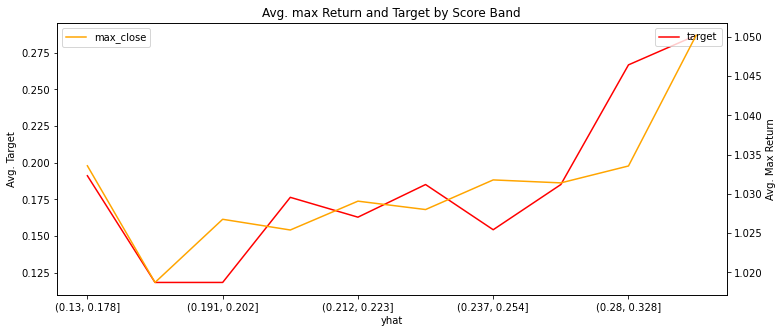

In [58]:
outcome = outcome_data.loc[today_dt][['code','max_close','min_close','target']].set_index('code')
X_outcome = X.merge(outcome, left_index=True, right_index=True, how='inner')

ranks = pd.qcut(X_outcome['yhat'], q = 10)
plt.figure(figsize=(12,5))
plt.title('Avg. max Return and Target by Score Band')
ax = X_outcome.groupby(ranks)['target'].mean().plot(color='red')
ax2 = ax.twinx()
ax2 = X_outcome.groupby(ranks)['max_close'].mean().plot(color='orange')
ax.set_ylabel('Avg. Target')
ax2.set_ylabel('Avg. Max Return')
ax.legend(loc=1)
ax2.legend(loc=2)
X_outcome.to_pickle('X_outcome.pkl')
